In [1]:
import os
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import networkx as nx
import pickle as pkl
import tqdm

In [7]:
pd.options.display.max_columns = 500

In [4]:
with open('./data/original_tweets.p', 'rb') as f:
    tweets = pkl.load(f)

In [5]:
len(tweets)

276260

In [8]:
tweets.head()

,contributors,coordinates,created_at,display_text_range,favorite_count,favorited,filter_level,geo,hashtags,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,mentions,occurence_date,place,possibly_sensitive,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,scopes,source,text,timestamp_ms,truncated,user,username,withheld_in_countries
0,None,None,2018-10-28 23:35:48+00:00,"[0, 109]",0,False,low,None,"[{'text': 'Warszawa', 'indices': [76, 85]}]",1056691029846491139,1056691029846491139,None,NaN,None,NaN,None,False,pl,[],2018-10-28 23:35:48+00:00,None,False,0,NaN,NaN,0,0,False,NaN,"<a href=""https://echowarszawy.pl"" rel=""nofollo...",KMPSP Warszawa: 23.10.2018 - Drzewo powalone n...,1540769748542,False,965943739809239040,EchoWarszawy,NaN
1,None,None,2018-10-28 23:35:51+00:00,"[48, 290]",0,False,low,None,[],1056691042106400768,1056691042106400768,SebNow82,1.056498e+18,1056497877588107266,9.009772e+17,900977200459075584,False,pl,"[SebNow82, ChiefRobert2, Immanuela_Kant, smok05]",2018-10-28 23:35:51+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@SebNow82 @ChiefRobert2 @Immanuela_Kant @smok0...,1540769751465,True,870751323549040640,dodi6319,NaN
2,None,None,2018-10-28 23:35:56+00:00,"[50, 330]",0,False,low,None,[],1056691065200304128,1056691065200304128,rafalch2,1.055956e+18,1055955548984741889,7.428777e+17,742877683646922752,False,pl,"[rafalch2, KLubnauer, Nowoczesna, wlodekczarza...",2018-10-28 23:35:56+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@rafalch2 @KLubnauer @Nowoczesna @wlodekczarza...,1540769756971,True,1025517195223281664,Fiona11701355,NaN
3,None,None,2018-10-28 23:35:59+00:00,"[20, 72]",0,False,low,None,[],1056691075727982592,1056691075727982592,wkrawcz1,1.056689e+18,1056688549007949824,7.167425e+17,716742538498060294,False,pl,"[wkrawcz1, pisorgpl]",2018-10-28 23:35:59+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@wkrawcz1 @pisorgpl W PiS to normalne. Wszyscy...,1540769759481,False,811556244892872704,Paul4Anka,NaN
4,None,None,2018-10-28 23:36:10+00:00,NaN,0,False,low,None,[],1056691121097752576,1056691121097752576,None,NaN,None,NaN,None,True,pl,[],2018-10-28 23:36:10+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Czasami żałuję, że Krysia mnie zablokowała😘",1540769770298,False,1004022955045728256,JanKiebasa3,NaN


## Extracting hashtag lists

In [6]:
htags = pd.DataFrame({'id':tweets.id, 'hashtags': tweets['hashtags'].apply(lambda htags_list: {htag['text'].lower() for htag in htags_list})})
htags = htags[htags.hashtags.str.len()>0]
print(len(htags))
htags['temp'] = htags.hashtags.apply(lambda x: '|'.join(x))
htags = htags.drop_duplicates('temp')
htags = htags.drop(columns=['temp'])
print(len(htags))
htags.head()

51167
19585


,id,hashtags
0,1056691029846491139,{warszawa}
26,1056692115512545280,{pis}
27,1056692209242771456,{cameronizm}
29,1056692268785172480,{bolsonaro}
31,1056692388440219650,"{wrocław, smolec, rpi, pogoda}"


In [7]:
sum(htags.hashtags.apply(len))

66305

In [8]:
unique_htags = set()
_ = htags.hashtags.map(lambda hashes: [unique_htags.add(h) for h in hashes])

len(unique_htags)

15652

# "Ungrouping" hashtag lists

In [15]:
neigh_lists = htags.copy()
neigh_lists = neigh_lists.set_index(['id'])
neigh_lists.hashtags = neigh_lists.hashtags.apply(list)
neigh_lists = (pd.melt(neigh_lists.hashtags.apply(pd.Series).reset_index(), 
                       id_vars=['id'],
                       value_name='hashtags')
               .set_index('id')
               .drop('variable', axis=1)
               .dropna()
               .sort_index()).reset_index()
neigh_lists

,id,hashtags
0,390850616508948480,huta
1,390850616508948480,warszawa
2,390850616508948480,wystawa
3,390850616508948480,bielany
4,411812537626161152,kongressp
5,411812537626161152,kempa
6,429555096075001857,mniejue
7,474241075620900864,wolnapolska25
8,474241075620900864,jow
9,474241075620900864,ciszawyborcza


In [10]:
hashtag_counts = neigh_lists.groupby('hashtags').agg({'id':'nunique'})
hashtag_counts

,id
hashtags,
0day,2
0hdlaniewiedzy,1
0sekund,1
100aferpis,3
100aut100lecie,1
100imy,1
100imypodblokiem,25
100lat,1
100latarchiwumaktnowych,1


count    15652.000000
mean         4.236200
std         45.608416
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
95%          9.000000
99%         39.000000
max       2851.000000
Name: id, dtype: float64


/home/mkosturek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


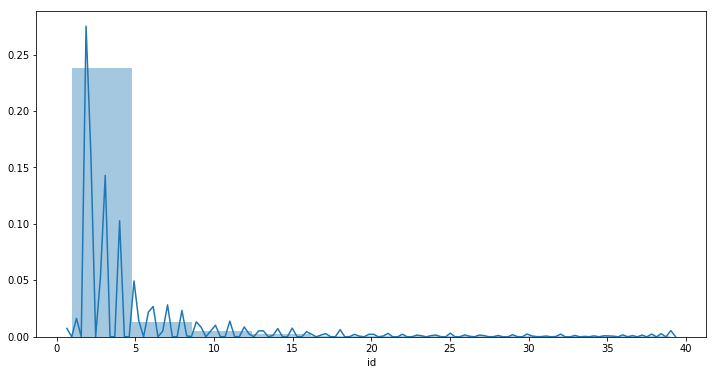

In [11]:
counts = hashtag_counts['id']
descr = counts.describe(percentiles=[.25, .5, .75, .95, .99])
print(descr)


fig = plt.figure(figsize=(12,6))
ax = sns.distplot(counts[(counts<=descr['99%']) & (counts >= 0)], bins=10)

count    15652.000000
mean         4.236200
std         45.608416
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
95%          9.000000
99%         39.000000
max       2851.000000
Name: id, dtype: float64


/home/mkosturek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


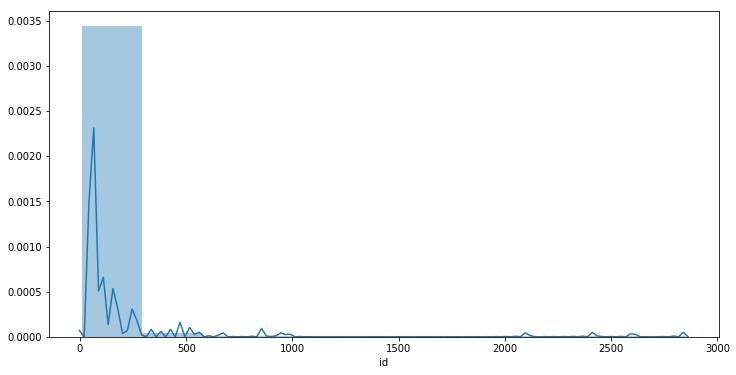

In [12]:
counts = hashtag_counts['id']
descr = counts.describe(percentiles=[.25, .5, .75, .95, .99])
print(descr)


fig = plt.figure(figsize=(12,6))
ax = sns.distplot(counts[(counts>=descr['95%'])], bins=10)

# Creating neighbourhood lists

In [16]:
print(len(neigh_lists))

neigh_lists = neigh_lists.merge(htags, on='id').rename(columns={'hashtags_x': 'hashtag',
                                                                'hashtags_y': 'coocurrent'})
temp = neigh_lists.copy()
neigh_lists.coocurrent = neigh_lists.coocurrent.apply(list)
neigh_lists = neigh_lists[['hashtag', 'coocurrent']].groupby('hashtag').agg({'coocurrent': 'sum'}).reset_index()
neigh_lists.coocurrent = neigh_lists.apply(lambda row: set(row['coocurrent']) - {row['hashtag']}, axis=1)
neigh_lists.head()


66305


,hashtag,coocurrent
0,0day,"{polskirap, caas, timetravel, polskihiphop, ra..."
1,0hdlaniewiedzy,{24hdlawarszawy}
2,0sekund,{}
3,100aferpis,"{idenawybory, kłamaćjakmorawiecki, kłamstwapis..."
4,100aut100lecie,"{pisdziele, 100latniepodleglosci, pis}"


# Building graph

In [17]:
G = nx.Graph()

for row in tqdm.tqdm_notebook(neigh_lists.itertuples()):
    G.add_node(row.hashtag)
    for cooc_htag in row.coocurrent:
        G.add_node(cooc_htag)
        G.add_edge(row.hashtag, cooc_htag)

In [18]:
G.size()

80533

In [19]:
len(G.nodes), len(G.edges)

(15652, 80533)

# Filtering out nodes with degree 0

In [22]:
min(dict(G.degree).values()), max(dict(G.degree).values())

(1, 3747)

In [21]:
degrees = dict(G.degree)

for node in degrees:
    if degrees[node]==0:
        G.remove_node(node)
len(G.nodes), len(G.edges)

(13681, 80533)

# Degree distribution

/home/mkosturek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


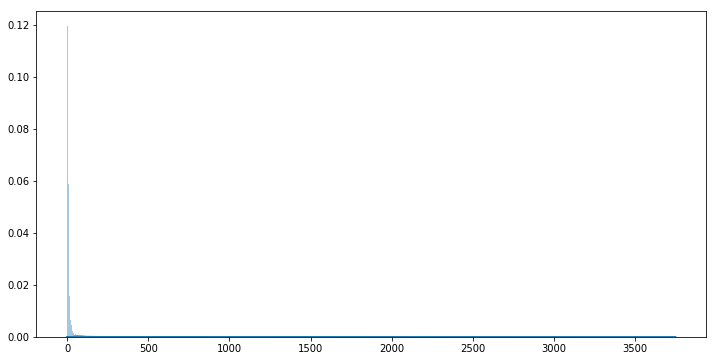

In [23]:
fig = plt.figure(figsize=(12,6))
ax = sns.distplot(list(dict(G.degree).values()), bins=1000)
# ax.set_xscale('log')

# Degree distr. below 95 percentile

count    13681.000000
mean        11.772970
std         57.131097
min          1.000000
25%          3.000000
50%          5.000000
75%         11.000000
95%         32.000000
max       3747.000000
dtype: float64


/home/mkosturek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


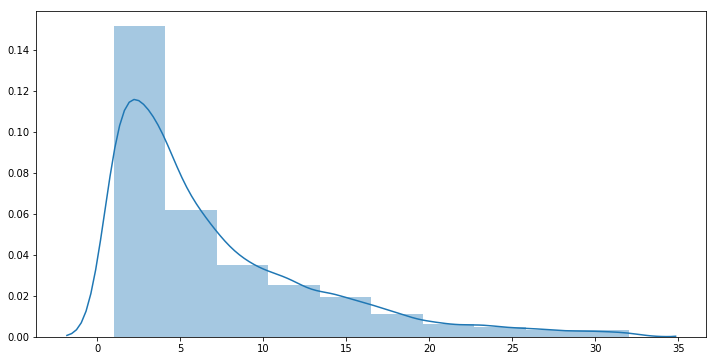

In [24]:
degrees = pd.Series(list(dict(G.degree).values()))
descr = degrees.describe(percentiles=[.25, .5, .75, .95])
print(descr)


fig = plt.figure(figsize=(12,6))
ax = sns.distplot(degrees[(degrees<=descr['95%']) & (degrees >= 0)], bins=10)
# ax.set_xscale('log')

# Graph visualisation trial

In [29]:
#pos = nx.layout.spring_layout(G, iterations=2)

# if you're brave enough - run for 20 iterations
pos = nx.layout.spring_layout(G, iterations=20)

/home/mkosturek/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


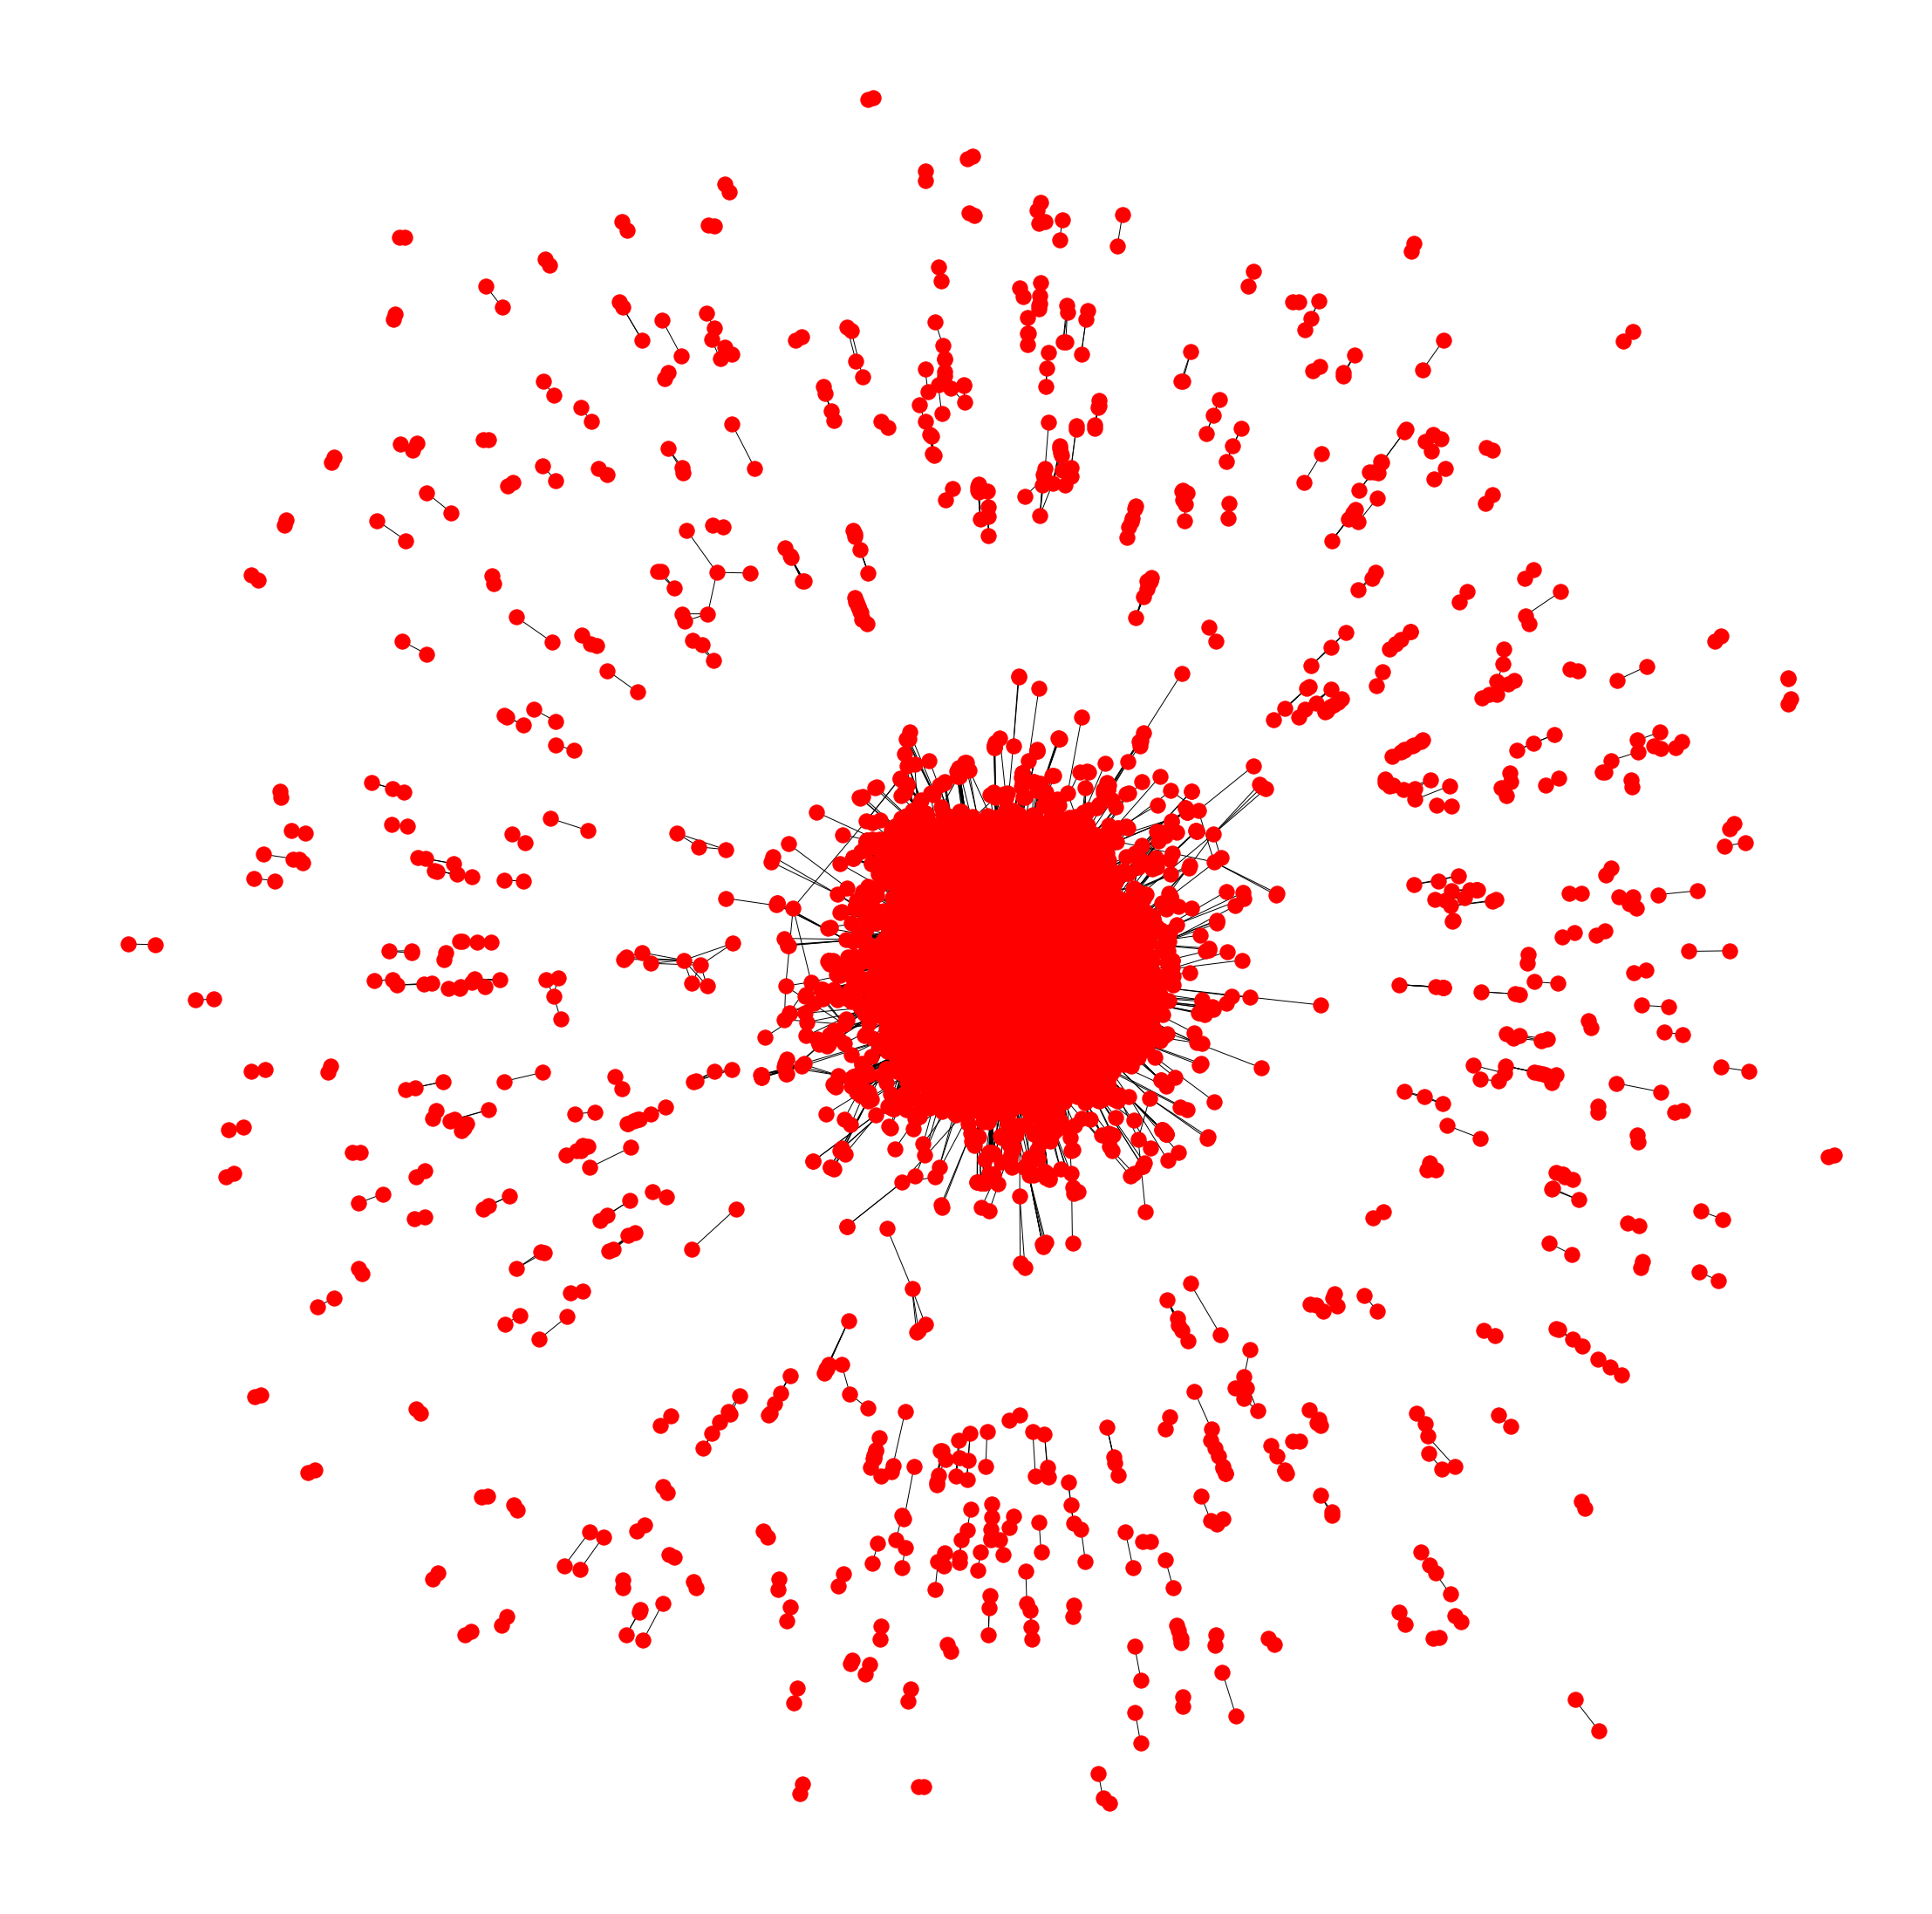

In [30]:
plt.figure(figsize=(30,30))
nx.draw(G, pos=pos)

# Leave just giant component

In [31]:
giant = max(nx.connected_component_subgraphs(G), key=len)

In [32]:
len(giant.nodes()), len(giant.edges())

(12758, 79517)

In [34]:
%%time
#pos = nx.layout.spring_layout(giant, iterations=2)

# if you're brave enough - run for 20 iterations
pos = nx.layout.spring_layout(giant, iterations=20)

/home/mkosturek/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


CPU times: user 2min 12s, sys: 680 ms, total: 2min 13s
Wall time: 2min 1s


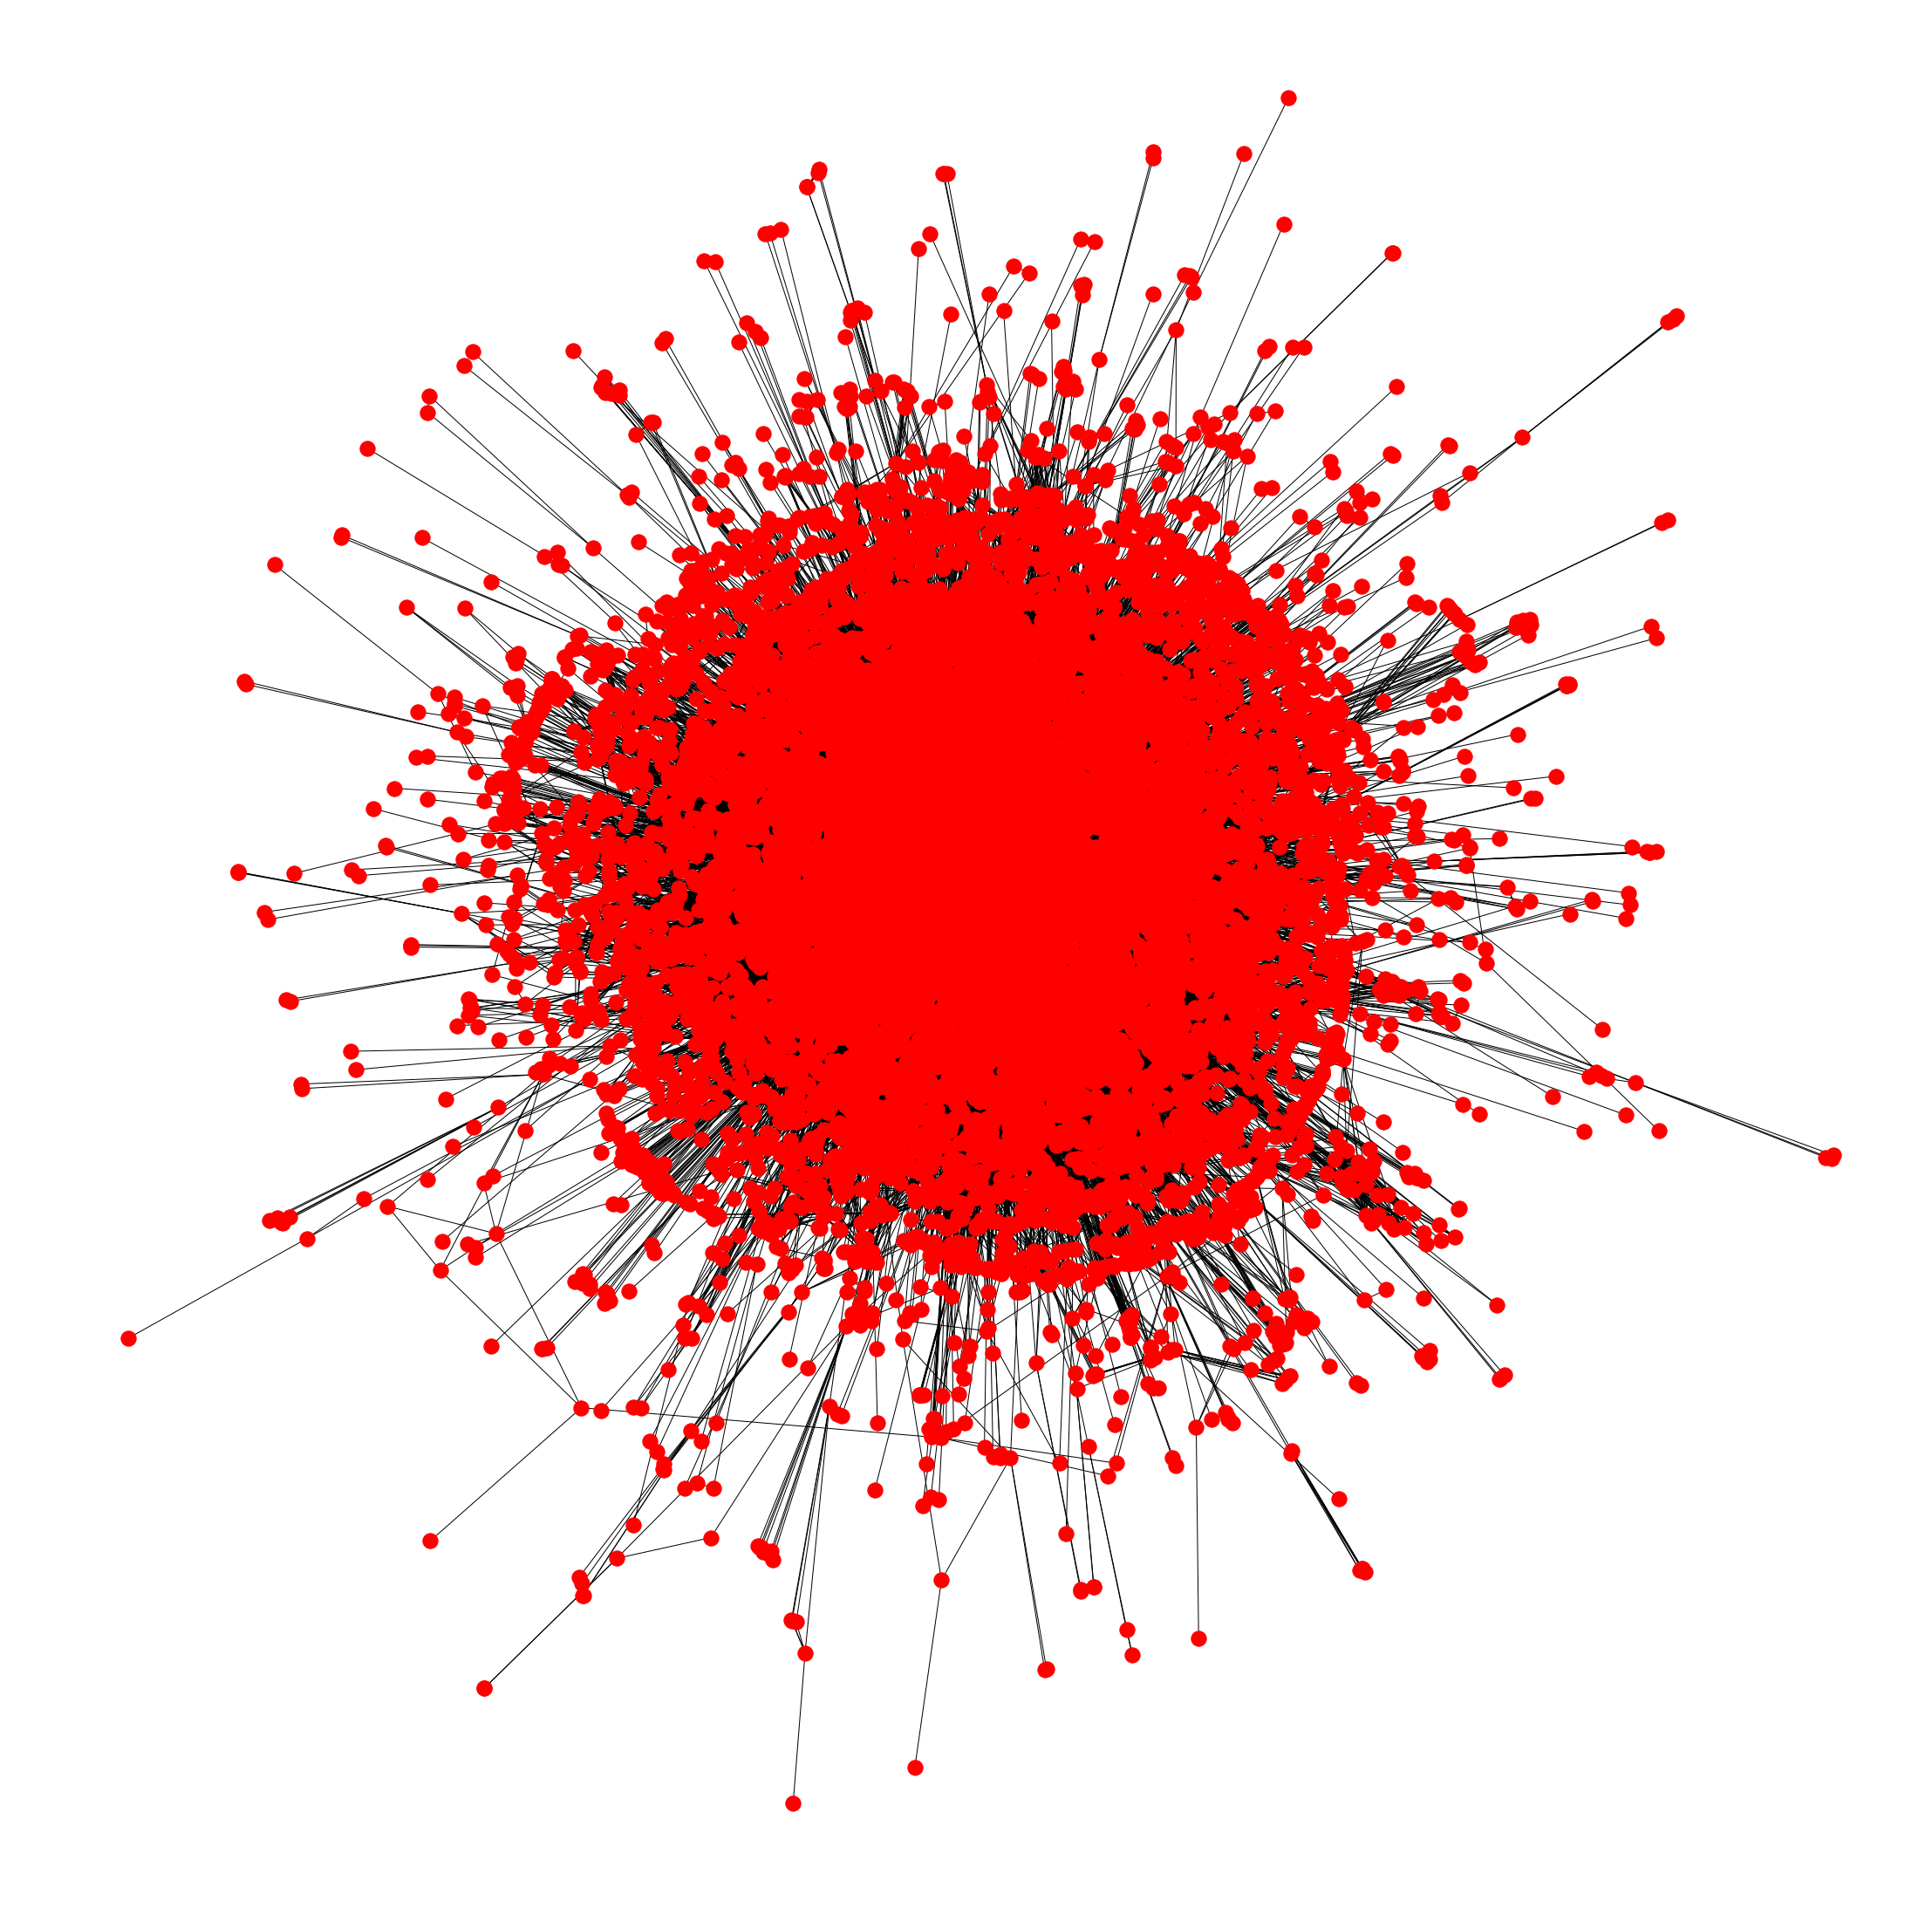

In [35]:
plt.figure(figsize=(30,30))
nx.draw(giant, pos=pos)

In [36]:
print(':(')

:(
